# Diffusion maps 1

#### Author: Yu-Jie Ho, 2019

## Abstract

This is my first sight to diffusion maps [1],  I study [Ann Lee's Matlab code](https://reurl.cc/E3Ykv) and simply convert it into Python. In order to understand the meaning of the code, I also read papers that describe this method [1, 2]. In the following article, I will show how Ann Lee constructs a diffusion map step by step, then demonstrate my Python code. Also, there's a paper provided a better way to build one map [3], it leads me to the [next project](), in which I will implement it's algorithm.

## Framework

Given a data set $X=\{x_1,...,x_n\} \in \mathbb{R}^p$, Ann Lee construct the diffusion maps by using following steps:

### 1. Define a kernel matrix

Let $K$ be a kernel matrix with entries $ K_{ij}=k(x_{i},x_{j}) $, where $k$ is the Guassian kernel
$$ k(x,y) = \exp(-\frac{\lVert x-y \rVert^2}{4\sigma}), $$
and $\sigma$ is a manually picked constant.

### 2. Construct a matrix that related to diffusion matrix

Diffusion matrix $P$ is a matrix that describe the connectivity between two data points, which can be consider as the probability of jumping from one point to another in one step of random walk [2].  
Consider a matrix $Q$, with it's entries $$ Q_{ij}=\frac{K_{ij}}{\sqrt{\sum_{j=1}^n K_{ij}} \sqrt{\sum_{i=1}^n K_{ij}}}. $$
We can find the relation between $Q$ and $P$ in the next step.

### 3. Find eigenvectors and eigenvalues of the diffusion matrix

The eigenvalues of $P$ is equal to the eigenvalues of $Q$, which is arrange in descending power.  
The right and left eigenvectors of $P$ are $$ \psi_k=e_k * e_1 $$ $$\phi_k=e_k / e_1 $$
respectively, where $e_k$ is the corresponding eigenvector of the k-th eigenvalue of $Q$, $e_1$ is the eigenvector of the first eigenvalue of $Q$, and the multiplication and division is applied to each element, not the matrix operations.

### 4. Define a diffusion map and treat each row as a point coordinate

Let $Y$ be a diffusion map, which map corrdinates between data and diffusion space [2], with its column
$$ Y_i=[\frac{\lambda_i}{1-\lambda_i} \psi_i] $$

Dimensional reduction is done by neglecting certain dimensions in the diffusion space, since the orthogonal left eigenvectors of $P$ form a basis for the diffusion space, and the associated coefficient indicate the importance of each dimension [2].

### 5. Cluster via k-means

Using k-means method to get the labeling of the datas, here k is a manually select number of groups.

## Implementation

Python code that implement diffusion maps using the steps above.

### 1. Import some libraries for programming

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### 2. Define functions

The functioning of get_K is to get the Guassian kernel matrix.

In [2]:
def get_K(D, sigma):
    list1=[]

    for i in range(n):
        for j in range(n):
            list1.append( exp(-D[i][j]*D[i][j]/(4*sigma)) )
    K = array(list1).reshape(n, n)
    
    return K    #Guassian kernel matrix

The functioning of get_Q is to get the matrix $Q$ we mention above.

In [3]:
from scipy.sparse import csr_matrix

def get_Q(K):
    list1=[]
    list2=[]
    
    for i in range(n): list1.append( sqrt(sum(K[i])) )
    v = array(list1).reshape(n,1)    #v_i=(sum_j(K[i][j]))^(1/2)
    
    Q = K/(v*v.T)    #v*v.T is a n*n symmetric matrix.
                     #the multiplication and division is applied to each element,
                     #not the matrix operations.
    
    #turn Q into a sparse matrix to speed up calculation
    threshold = 5e-6
    for i in range(n):
        for j in range(n):
            if Q[i][j]>threshold: list2.append(1.)
            else: list2.append(0.)
    a = array(list2).reshape(n, n)
    Q = csr_matrix(Q*a, dtype=float)
    
    return Q    #Q is the matrix we define earlier, i.e., Q=D^(-1/2)KD^(-1/2)

The functioning of get_eig is to get eigenvalues and eigenvectors of the diffusion matrix.

In [4]:
from scipy.sparse.linalg import svds

def get_eig(Q, c):
    list1=[]
    list2=[]
    
    [U, S, V] = svds(Q, c+1)    #compute the largest c singular values/vectors for a sparse matrix
                               #since Q is a real symmetric matrix, singular values and non-negative
                               #eigenvalues coincide

    eigenvals = flip(S).reshape(c+1,1)
    
    for i in range(n): U[i]=flip(U[i])
    for i in range(n):
        for j in range(c+1):
            list1.append(U[i][j]/U[i][0])
            list2.append(U[i][j]*U[i][0])
            
    psi = array(list1).reshape(n, c+1)
    phi = array(list2).reshape(n, c+1)

    
    return [psi, phi, eigenvals]    #eigenvectors and eigenvalues of diff matrix

The functioning of get_Y is to get the diffusion map.

In [5]:
def get_Y(eigenvals, c, psi, t):
    list1=[]
    
    if t!=0:
        for i in range(n):
            for j in range(c):
                list1.append(psi[i][j+1]*pow(eigenvals[j+1], t))
        Y = array(list1).reshape(n, c)
    else:
        for i in range(n):
            for j in range(c):
                list1.append( psi[i][j+1]*(eigenvals[j+1]/(1-eigenvals[j+1])) )
        Y = array(list1).reshape(n, c)
        
    return Y    #Y is the diffusion map

The functioning of diffusion_kmeans and distortionMinimization is to cluster via k-means.

In [6]:
from math import ceil
import random as rnd

def diffusion_kmeans(Y, clusters, phi0, Niter, epsilon):
    
    d=len(Y[0])
    aD=Inf

    for i in range(Niter):
        tmp_ind = rnd.sample(range(n), clusters)
        
        list1=[]
        for p in tmp_ind:
            for q in range(d):
                list1.append(Y[p-1][q])
        c_0 = array(list1).reshape(clusters, d)
    
        idx, c, cindex, D, DX = distortionMinimization(Y, phi0, clusters, c_0, 0, epsilon)

        if D<aD:
            aD=D
            aDX=DX
            a_idx=idx
            ac=c
    D=aD
    DX=aDX
    idx=a_idx
    C=ac
    
    return idx, C, D, DX

In [7]:
def distortionMinimization(Y, phi0, clusters, c_0, DspFlag, epsilon):
    list1=[]
    list2=[]
    list3=[]
    
    d=len(Y[0])
    c=c_0
    oldD=Inf
    MaxIter=1000
    
    for i in range(MaxIter):
        for j in range(clusters):
            for p in range(n):
                for q in range(d):
                    list1.append(Y[p][q]-c[j][q])
            dX = (array(list1).reshape(n,d)).T    #dX=dX.T
            list1.clear()
            
            list2.append(sum(dX.conj()*dX,axis=0))
        DX = (array(list2).reshape(clusters,n)).T
        list2.clear()
        
        for j in range(n):
            list1.append(min(DX[j]))
            list2.append(argmin(DX[j])+1)
        Dtmp = array(list1).reshape(1,n)
        S = array(list2).reshape(n,1)
        
        list1.clear()
        list2.clear()
        
        ind=[]
        for j in range(clusters):
            for p in range(n):
                if S[p]==j+1: ind.append(p)
            if len(ind)==0:
                mx = max(Dtmp[0])
                m = argmax(Dtmp[0])
                S[m][0] = j+1
                Dtmp[0][m] = 0
            ind.clear()

        for j in range(clusters):
            for p in range(n):
                if S[p]==j+1: ind.append(p)
            for p in range(d):
                tempsum=0
                tempsum2=0
                for q in ind: tempsum += phi0[q][0]
                for q in ind: tempsum2 += phi0[q][0]*Y[q][p]/tempsum
                list3.append(tempsum2)
            ind.clear()
        c = array(list3).reshape(clusters,d)
        
        list3.clear()
        
        D = dot(Dtmp, phi0)
        
        
        if (oldD-D)/D < epsilon: break
        oldD=D
        
        
    for j in range(clusters):
        for p in range(n):
            for q in range(d):
                list1.append(Y[p][q]-c[j][q])
        dX = (array(list1).reshape(n,d)).T    #dX=dX.T
        list1.clear()
        list2.append(sum(dX.conj()*dX,axis=0))
        DX = array(list2).reshape(n,1)
        list2.clear()
            
        dummy = min(DX.T[0])
        list3.append( argmin(DX.T[0]) )
    cindex = array(list3).reshape(clusters,1)
    
    
    return S, c, cindex, D, DX

### 3. Load data

In [8]:
from scipy.io import loadmat

ori = loadmat('Data.mat')

n = len(ori['data'])       #number of points
p = len(ori['data'][0])    #dimension of points

for i in range(n):
    plt.scatter(ori['data'][i][0],ori['data'][i][1], s=2, c="blue")
plt.title("Original data")
plt.gcf().set_size_inches(6,6)
plt.show()

### 4. Set parameters and do the calculation

##### 4.1. Set parameters for constructing a diffusion map

D : a n*n matrix with pairwise Euclidean distance as its entries  
sigma : scaling parameter $\sigma$ in the Guassian kernel function  
c : the largest $c$ eigenvalues, that is, the largest dimension we consider  
t : 'time'

By taking powers of $P$, we increase the number of steps taken, that is, $P_{ij}^{t}$ sum all paths that take $t$ steps from $x_i$ to $x_j$, this is called the diffusion process.  
When increasing value $t$, the probability of following a path along the underlying geometric structure of the data set increases, since along the geometric structure, points are dense and therefore highly connected, pathways form along short and high probability jumps [2].

In [9]:
from scipy.spatial.distance import squareform, pdist
D = squareform(pdist(ori['data']))
c = 10
t = 0
flag_t = 0

Ann Lee guess the correct sigma by considering the distance between one point to its k-nearest neighbor point.

In [10]:
#guess the correct sigma
D_sort = sort(D,1)
k = 30       #k-nearest point of one point

dist_k=[]    #distance between one point and its k-nearest neighbor point
for i in range(len(D_sort)): dist_k.append( D_sort[i][k+1] )
    
sigma = median(dist_k)*median(dist_k)/2    #guessed sigma
print("suggest sigma = ", sigma)

suggest sigma =  0.00436767844472376


Manually pick one sigma.

In [11]:
sigma = 0.00025

###### 4.2. Compute the eigenvalues and eigenvectors of diffusion matrix and get the diffusion map

In [12]:
def diffuse(D, sigma, c, t):
    
    K = get_K(D, sigma)
    Q = get_Q(K)
    [psi, phi, eigenvals] = get_eig(Q, c)
    Y = get_Y(eigenvals, c, psi, t)

    return Y, eigenvals, psi, phi

In [13]:
Y, eigenvals, psi, phi = diffuse(D, sigma, c, t)

##### 4.3. Set parameters for clustering via k-means

clusters : number of clusters  
Niter : number of iterations to repeat the clustering with new IC  
epsilon : relative distortion  
phi0 : first left eigenvector of P

In [14]:
clusters=3
Niter=100
epsilon=1e-3

list1=[]
for i in range(n): list1.append(phi[i][0])
phi0=array(list1).reshape(n,1)

###### 4.4. Diffusion k-means clustering

In [15]:
idx, C, ERR, DX = diffusion_kmeans(Y, clusters, phi0, Niter, epsilon)

### 5. Display the result

##### 5.1. Show the fall-off of eigenvalues of diffusion matrix

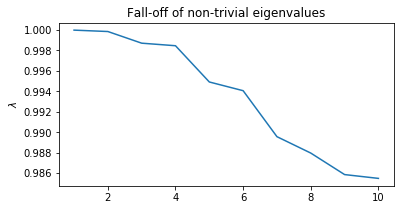

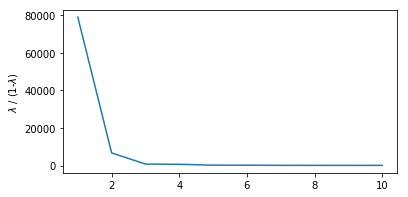

In [16]:
plt.plot(range(1,c+1),eigenvals[1:c+1])
plt.title('Fall-off of non-trivial eigenvalues')
plt.ylabel('$\lambda$')
plt.gcf().set_size_inches(6,3)
plt.show()

if flag_t:
    plt.plot(range(1,c+1), pow(eigenvals[1:c+1], t))
    plt.ylabel('$\lambda$^t')
else:
    plt.plot(range(1,c+1), eigenvals[1:c+1]/(1-eigenvals[1:c+1]) )
    ylabel('$\lambda$ / (1-$\lambda$)')
plt.gcf().set_size_inches(6,3)
plt.show()

##### 5.2. Show the diffusion space

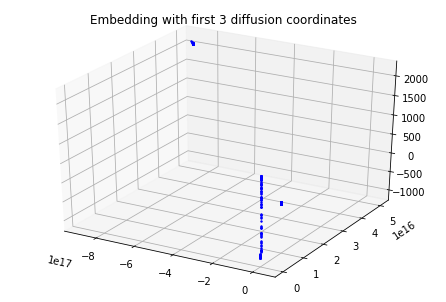

In [17]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = Axes3D(fig)
for i in range(n): ax.scatter(Y[i][0],Y[i][1],Y[i][2],s=2, c='b')
ax.set_title('Embedding with first 3 diffusion coordinates')
plt.show()

##### 5.3. Show the labeling

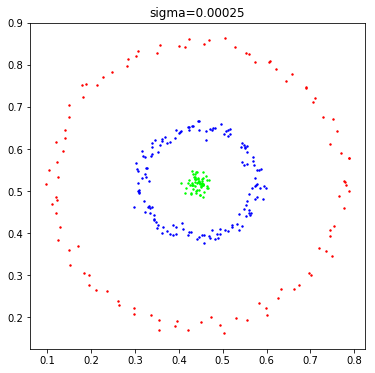

In [18]:
cmap = cm.brg
norm = Normalize(1, clusters)

for i in range(n):
    plt.scatter(ori['data'][i][0], ori['data'][i][1], s=2, c=cmap(norm(idx[i])) )
plt.title('sigma=0.00025')
plt.gcf().set_size_inches(6,6)
plt.show()

## Conclusion

After converting and understanding the meaning of the code, I can roughly describe this dimensionality reduction method. Although some of Ann Lee's code does not follow the original description of the diffusion map, (e.g., when finding the eigenvectors of diffusion map, unlike Ann Lee's method, [1] suggested we to multiple $Q$'s eigenvectors with a diagonal matrix related to $K$), but it turns out both way can lead us to an effective labeling of data (see the implement of the original description in my [another project]()). And as I mention above, I will then show a more convenient way to construct a diffusion map, which provided by [3], in my [next project]().

## References

[1] R.R. Coifman and S. Lafon, Diffusion maps, Applied and computational harmonic analysis, 21:5–30, 2006  
[2] J. de la Porte, B. M. Herbst, W. Hereman and S. J. van der Walt., An Introduction to Diffusion Maps, Proceedings of the Nineteenth Annual Symposium of the Pattern Recognition Association of South Africa, 2008  
[3] L. Zelnik-Manor and P. Perona, Self-Tuning Spectral Clustering, Advances in Neural Information Processing Systems 17:1601-1608, 2005